<a href="https://colab.research.google.com/github/DjordjeSevic/shipDetection/blob/main/DetekcijaBroda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detekcija broda, set podataka i opis algoritama

Detekcija objekata je jedan od osnovnih problema koji je danas rešen pomoću Deep Learning-a, gotovo svakodnevno i sami koristimo neki tehnički uređaj koji vrši detekciju objekata, a da toga možda nismo ni svesni. Rešenje ovog problema za različite objekte doprinelo je unapređenju velikog broja industrija, a kao najbolji primer može se uzeti auto industrija i medicina.

Zadatak - Detektovati objekte broda na satelitskim slikama.

Data set na kojem će se raditi detektovanje brodova se nalazi na sledećem linku:

https://drive.google.com/file/d/1VHbj77uYVjcEh9_e4Y6wgpIMI-8Q2YBo/view

Set podataka za trening se sastoji iz 44533 slika dok testni set sadrži 6872. slike.

Neki od najpopularnijih algoritama za detekciju objekata su:

*   Faster R-CNN
*   Single Shot Detection
*   You Only Look Once
*   RetinaNet




***Faster R-CNN***

*Faster* *R-CNN* model je jedna od najboljih verzija *R-CNN* porodice i značajno poboljšava brzinu performansi u odnosu na svoje prethodnike. Dok modeli *R-CNN* i *Fast* *R-CNN* koriste algoritam selektivne pretrage za izračunavanje predloga regiona, metoda *Faster* *R-CNN* zamenjuje ovaj postojeći metod sa superiornom mrežom predloga regiona. Mreža predloga regiona (*RPN*) izračunava slike iz širokog opsega i različitih razmera kako bi proizvela efektivne rezultate.

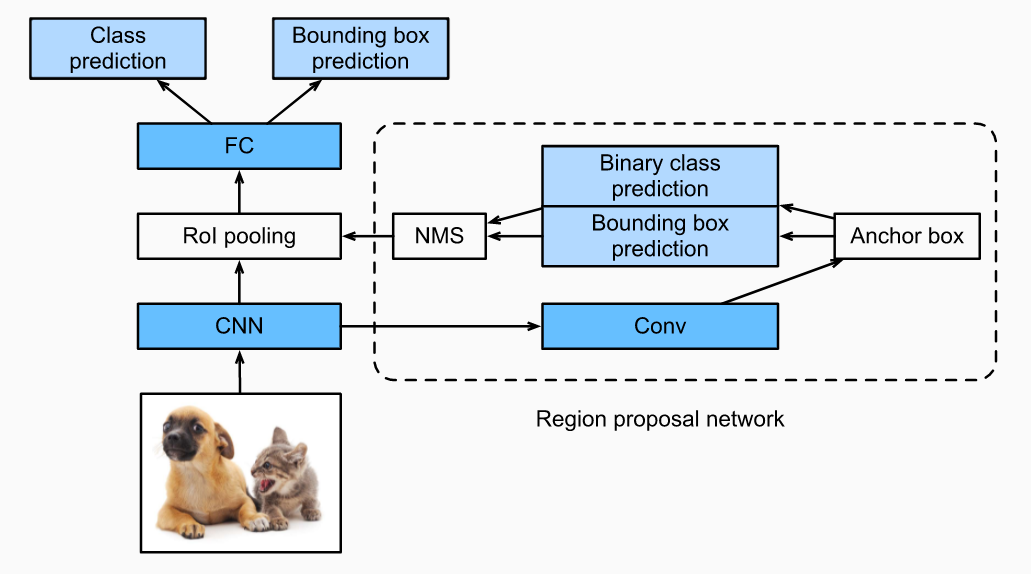

***Single Shot Detection***

*SSD* za *multi-box* predviđanja je jedan od najbržih načina da se postigne izračunavanje zadataka detekcije objekata u realnom vremenu. Dok metodologije *Faster R-CNN* mogu postići visoku tačnost predviđanja, ukupan proces je prilično dugotrajan i zahteva da se zadatak u realnom vremenu izvodi brzinom od oko 7 frejmova u sekundi, što je daleko od poželjnog.

*SSD* rešava ovaj problem poboljšanjem frejmova u sekundi na skoro pet puta više od Faster R-CNN modela. On uklanja korišćenje mreže predloga regiona i umesto toga koristi funkcije višestrukih razmera i podrazumevane okvire.

Iako značajno poboljšava performanse, pati od smanjenja rezolucije slika na niži kvalitet. Zbog ovoga, nećemo koristiti ovaj model za detekciju broda jer su slike satelitske i već su lošije rezolucije. Takođe nije baš najbolji algoritam za detektovanje malih objekata na slikama, a brodovi na satelitskim slikama mogu biti prilično mali.

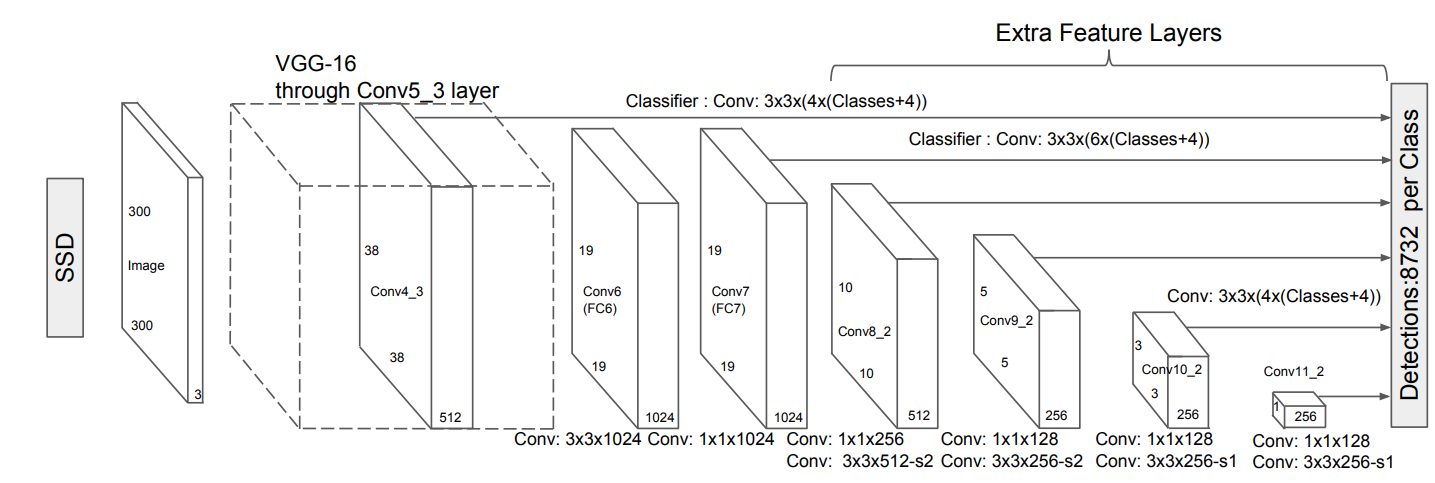

***You Only Look Once***

*Yolo* arhitektura koristi tri primarne terminologije da bi postigla svoj cilj detekcije objekata. Prvi koncept u *Yolo* modelu su rezidualni blokovi. U prvom arhitektonskom dizajnu, koristili su preostale blokove 7×7 za kreiranje mreža na određenoj slici. Svaka od ovih mreža deluje kao centralne tačke i u skladu sa tim se pravi posebno predviđanje za svaku od ovih mreža. U drugoj tehnici, svaka od centralnih tačaka za određeno predviđanje se razmatra za kreiranje graničnih kutija. Dok zadaci klasifikacije dobro funkcionišu za svaku mrežu, složenije je odvojiti granične okvire za svako od predviđanja koja su napravljena. Treća i poslednja tehnika je upotreba preseka unije (*IOU*) za izračunavanje najboljih graničnih okvira za određeni zadatak detekcije objekata. Pored velike brzine računanja, *Yolo* algoritam takođe uspeva da obezbedi opštu visoku tačnost uz smanjenje pozadinskih grešaka koje se vide u drugim metodama.

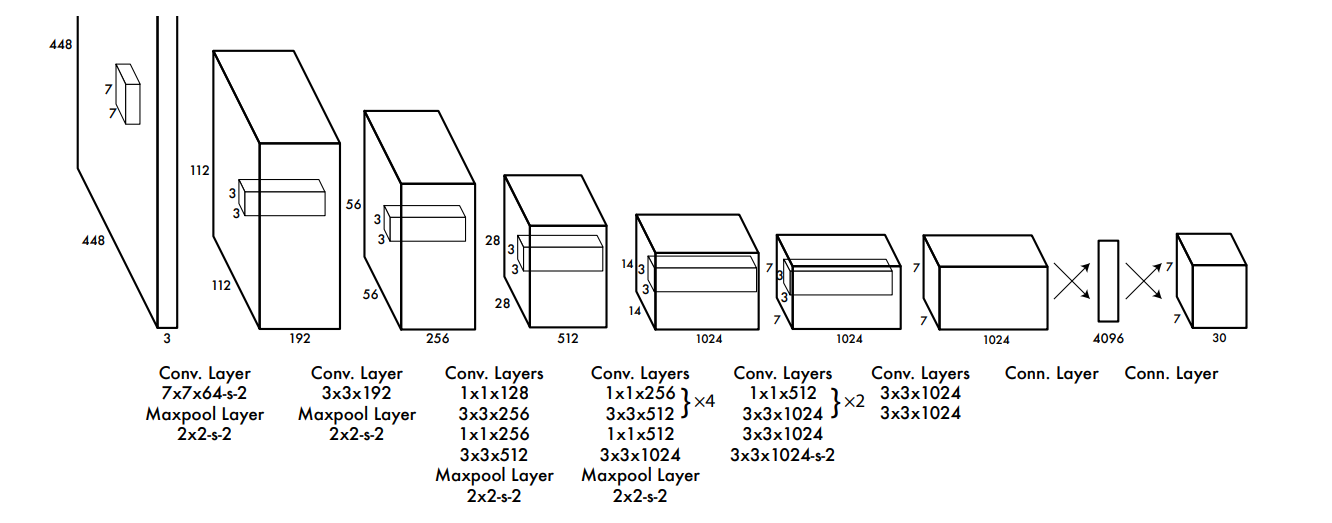

***RetinaNet***

Algoritam koji je zadržao istu brzinu kao i *SSD* i *YOLO*, takođe je u stanju da se takmiči sa porodicom *R-CNN* u pogledu tačnosti. Zbog ovih razloga, *RetinaNet* model nalazi veliku upotrebu u otkrivanju objekata putem satelitskih snimaka i iz tog razloga će biti prikazana njegova implementacija za gore opisani problem detekcije broda.

*RetinaNet* arhitektura je izgrađena na takav način da su prethodna izdanja *SSD*-a donekle izbalansirana kako bi se proizveli efektivniji i efikasniji rezultati. U ovoj arhitekturi modela, gubitak unakrsne entropije u prethodnim modelima je zamenjen fokalnim gubitkom. Fokalni gubitak rešava probleme neravnoteže klase koji postoje u arhitekturama kao što su *YOLO* i *SSD*.

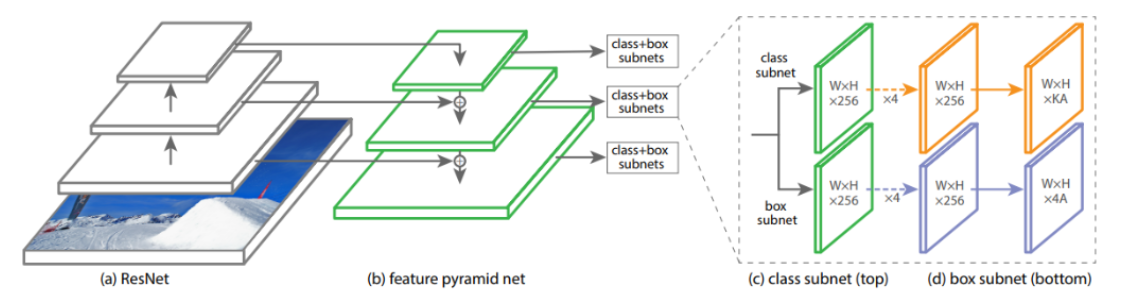

**Literatura**

1. https://neptune.ai/blog/object-detection-algorithms-and-libraries
2. https://imageai.readthedocs.io/en/latest/detection/
3. https://viso.ai/deep-learning/object-detection/#:~:text=on%20Viso%20Suite-,Most%20Popular%20Object%20Detection%20Algorithms,the%20single%2Dshot%20detector%20family.

# Implementacija *MASK RCNN*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v2
import os
import time
import sys

from skimage.morphology import label
from imageio.v2 import imread

In [2]:
TRAINING_VALIDATION_RATIO = 0.2
WORKING_DIR = '/content/drive/MyDrive/DetekcijaBroda'
INPUT_DIR = '/content/drive/MyDrive/DetekcijaBroda'
OUTPUT_DIR = '/content/drive/MyDrive/DetekcijaBroda'
LOGS_DIR = os.path.join(WORKING_DIR, "logs")
TRAIN_DATA_PATH = os.path.join(INPUT_DIR, 'train_v2')
TEST_DATA_PATH = os.path.join(INPUT_DIR, 'test_v2')
SAMPLE_SUBMISSION_PATH = os.path.join(INPUT_DIR, 'sample_submission_v2.csv')
TRAIN_SHIP_SEGMENTATIONS_PATH = os.path.join(INPUT_DIR, 'train_ship_segmentations_v2.csv')
MASK_RCNN_PATH = os.path.join(WORKING_DIR, 'maskRcnn-main')
COCO_WEIGHTS_PATH = os.path.join(WORKING_DIR, "mask_rcnn_coco.h5")
SHIP_CLASS_NAME = 'ship'
IMAGE_WIDTH = 768
IMAGE_HEIGHT = 768
SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT)
test_ds = os.listdir(TEST_DATA_PATH)
train_ds = os.listdir(TRAIN_DATA_PATH)

In [3]:
masks = pd.read_csv(TRAIN_SHIP_SEGMENTATIONS_PATH)
masks.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


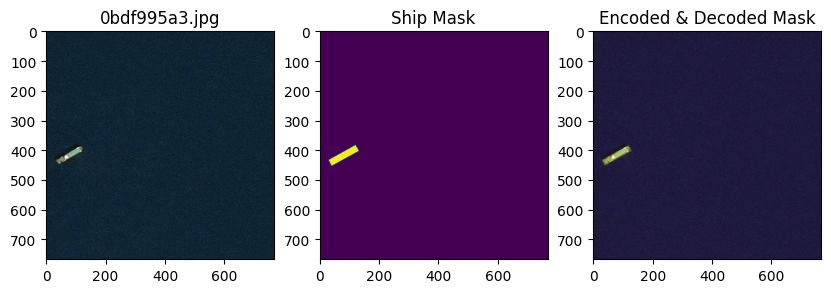

0bdf995a3.jpg  Check Decoding->Encoding RLE_0: 1 -> RLE_1: 1


In [4]:
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_encode(img):

    pixels = img.T.flatten()

    pixels = np.concatenate([[0], pixels, [0]])

    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1

    runs[1::2] -= runs[::2]

    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=SHAPE):

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def masks_as_image(in_mask_list, shape=SHAPE):
    all_masks = np.zeros(shape, dtype = np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

def shows_decode_encode(image_id, path=TRAIN_DATA_PATH):

    fig, axarr = plt.subplots(1, 3, figsize = (10, 5))
    img_0 = imread(os.path.join(path, image_id))
    axarr[0].imshow(img_0)
    axarr[0].set_title(image_id)
    rle_1 = masks.query('ImageId=="{}"'.format(image_id))['EncodedPixels']
    img_1 = masks_as_image(rle_1)
    axarr[1].imshow(img_1[:, :, 0])
    axarr[1].set_title('Ship Mask')
    rle_2 = multi_rle_encode(img_1)
    img_2 = masks_as_image(rle_2)
    axarr[2].imshow(img_0)
    axarr[2].imshow(img_2[:, :, 0], alpha=0.3)
    axarr[2].set_title('Encoded & Decoded Mask')
    plt.show()
    print(image_id , ' Check Decoding->Encoding',
          'RLE_0:', len(rle_1), '->',
          'RLE_1:', len(rle_2))

shows_decode_encode('0bdf995a3.jpg')


unique_img_ids groupby took: 4.714045763015747


,ImageId,ships,RleMaskList
48294,4065b93a0.jpg,1,[172166 3 172928 9 173693 12 174461 13 175229 ...
147684,c46fc340f.jpg,1,[195668 2 196434 4 197200 7 197967 8 198735 9 ...
121342,a1541f655.jpg,4,[153078 1 153845 3 154612 6 155380 7 156147 9 ...


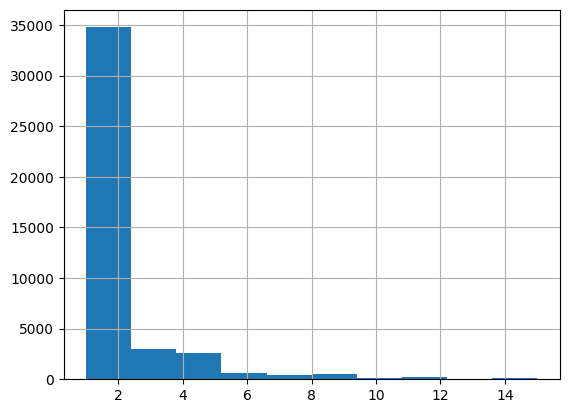

In [5]:
masks['ships'] = masks['EncodedPixels'].map(lambda encoded_pixels: 1 if isinstance(encoded_pixels, str) else 0)

start_time = time.time()
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'})
unique_img_ids['RleMaskList'] = masks.groupby('ImageId')['EncodedPixels'].apply(list)
unique_img_ids = unique_img_ids.reset_index()
end_time = time.time() - start_time
print("unique_img_ids groupby took: {}".format(end_time))
unique_img_ids = unique_img_ids[unique_img_ids['ships'] > 0]
unique_img_ids['ships'].hist()
unique_img_ids.sample(3)

34044 training masks
8512 validation masks


<Axes: >

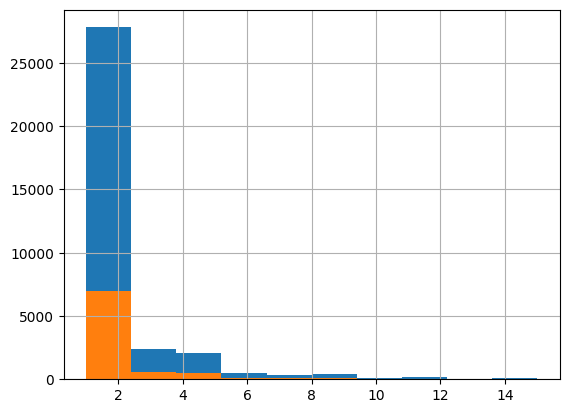

In [6]:
from sklearn.model_selection import train_test_split
train_ids, val_ids = train_test_split(unique_img_ids,
                 test_size = TRAINING_VALIDATION_RATIO,
                 stratify = unique_img_ids['ships'])
print(train_ids.shape[0], 'training masks')
print(val_ids.shape[0], 'validation masks')
train_ids['ships'].hist()
val_ids['ships'].hist()

In [7]:
if not os.path.exists(MASK_RCNN_PATH):
    ! wget https://github.com/leekunhee/Mask_RCNN/archive/master.zip -O Mask_RCNN-master.zip
    ! unzip Mask_RCNN-master.zip 'Mask_RCNN-master/mrcnn/*'
    ! rm Mask_RCNN-master.zip

--2023-06-18 11:19:03--  https://github.com/leekunhee/Mask_RCNN/archive/master.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/leekunhee/Mask_RCNN/zip/refs/heads/master [following]
--2023-06-18 11:19:03--  https://codeload.github.com/leekunhee/Mask_RCNN/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 192.30.255.121
Connecting to codeload.github.com (codeload.github.com)|192.30.255.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘Mask_RCNN-master.zip’

Mask_RCNN-master.zi     [    <=>             ]  70.69M  4.48MB/s    in 17s     

2023-06-18 11:19:22 (4.08 MB/s) - ‘Mask_RCNN-master.zip’ saved [74126865]

Archive:  Mask_RCNN-master.zip
111ab9ca98fef398cadd46172fa4dc6e1043f083
replace Mask_RCNN-master/mrcnn/__init__.py? [y]e

In [14]:
!pip install keras==2.12.0
sys.path.append('/content/Mask_RCNN-master/')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0


ModuleNotFoundError: ignored

In [26]:
class DetekcijaBrodaDataset(utils.Dataset):
    def __init__(self, image_file_dir, ids, masks, image_width=IMAGE_WIDTH, image_height=IMAGE_HEIGHT):
        super().__init__(self)
        self.image_file_dir = image_file_dir
        self.ids = ids
        self.masks = masks
        self.image_width = image_width
        self.image_height = image_height

        self.add_class(SHIP_CLASS_NAME, 1, SHIP_CLASS_NAME)
        self.load_dataset()

    def load_dataset(self):
        for index, row in self.ids.iterrows():
            image_id = row['ImageId']
            image_path = os.path.join(self.image_file_dir, image_id)
            rle_mask_list = row['RleMaskList']
            self.add_image(
                SHIP_CLASS_NAME,
                image_id=image_id,
                path=image_path,
                width=self.image_width, height=self.image_height,
                rle_mask_list=rle_mask_list)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        rle_mask_list = info['rle_mask_list']
        mask_count = len(rle_mask_list)
        mask = np.zeros([info['height'], info['width'], mask_count],
                        dtype=np.uint8)
        i = 0
        for rel in rle_mask_list:
            if isinstance(rel, str):
                np.copyto(mask[:,:,i], rle_decode(rel))
            i += 1
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info['source'] == SHIP_CLASS_NAME:
            return info['path']
        else:
            super(self.__class__, self).image_reference(image_id)

In [40]:
class DetekcijaBrodaGPUConfig(Config):
    NAME = '/physical_device:GPU:0'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    NUM_CLASSES = 2
    IMAGE_MIN_DIM = IMAGE_WIDTH
    IMAGE_MAX_DIM = IMAGE_WIDTH
    STEPS_PER_EPOCH = 2
    VALIDATION_STEPS = 1
    SAVE_BEST_ONLY = True
    DETECTION_MIN_CONFIDENCE = 0.95
    DETECTION_NMS_THRESHOLD = 0.05

config = DetekcijaBrodaGPUConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.05
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  768
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  768
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [768 768   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

In [41]:
start_time = time.time()
dataset_train = DetekcijaBrodaDataset(image_file_dir=TRAIN_DATA_PATH, ids=train_ids, masks=masks)
dataset_train.prepare()
dataset_val = DetekcijaBrodaDataset(image_file_dir=TRAIN_DATA_PATH, ids=val_ids, masks=masks)
dataset_val.prepare()

image_ids = np.random.choice(dataset_train.image_ids, 1)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)

end_time = time.time() - start_time
print("dataset prepare: {}".format(end_time))

FileNotFoundError: ignored

In [42]:
start_time = time.time()
model = modellib.MaskRCNN(mode="training", config=config, model_dir=WORKING_DIR)

import errno
try:
    weights_path = model.find_last()
    load_weights = True
except FileNotFoundError:
    load_weights = True
    weights_path = COCO_WEIGHTS_PATH
    utils.download_trained_weights(weights_path)

if load_weights:
    print("Loading weights: ", weights_path)
    model.load_weights(weights_path, by_name=True, exclude=[
                "mrcnn_class_logits", "mrcnn_bbox_fc",
                "mrcnn_bbox", "mrcnn_mask"])

end_time = time.time() - start_time
print("loading weights: {}".format(end_time))


... done downloading pretrained model!
Loading weights:  /content/drive/MyDrive/DetekcijaBroda/mask_rcnn_coco.h5
loading weights: 15.173426866531372


In [12]:
!pip install keras 2.12.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement 2.12.0 (from versions: none)
ERROR: No matching distribution found for 2.12.0


In [44]:
start_time = time.time()
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE * 1.5,
            epochs=2,
            layers='all')
end_time = time.time() - start_time
print("Train model: {}".format(end_time))


Starting at epoch 0. LR=0.0015

Checkpoint Path: /physical_device:gpu:020230618T1105/mask_rcnn_/physical_device:gpu:0_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a

KeyboardInterrupt: ignored

In [ ]:
class InferenceConfig(DetekcijaBrodaGPUConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
infer_model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=WORKING_DIR)

model_path = infer_model.find_last()

print("Loading weights from ", model_path)
infer_model.load_weights(model_path, by_name=True)

image_id = np.random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config,
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                            dataset_train.class_names, figsize=(8, 8))

results = infer_model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names, r['scores'])

image_ids = np.random.choice(dataset_val.image_ids, 20)
APs = []
inference_start = time.time()
for image_id in image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    results = infer_model.detect([image], verbose=1)
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names, r['scores'])

    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)

inference_end = time.time()
print('Inference Time: %0.2f Minutes'%((inference_end - inference_start)/60))
print("mAP: ", np.mean(APs))